In [17]:
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import ProgressBar
import matplotlib.pylab as plt

from dask.distributed import Client,LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)

client = Client(processes=False)

dir = "/data/home/hamiddashti/hamid/nasa_above/greeness/"
out_dir = "/data/home/hamiddashti/hamid/nasa_above/greeness/working/"


def dist_matrix(x_size, y_size):
    import numpy as np

    a1 = np.floor(x_size / 2)
    a2 = np.floor(y_size / 2)
    x_arr, y_arr = np.mgrid[0:x_size, 0:y_size]
    cell = (a1, a2)
    dists = np.sqrt((x_arr - cell[0]) ** 2 + (y_arr - cell[1]) ** 2)
    dists[int(a1), int(a2)] = np.nan
    return dists


WINSIZE = 3
dist_m = dist_matrix(WINSIZE, WINSIZE)

percent_cover = xr.open_dataarray(
    dir + "data/processed_data/percent_cover/percent_cover.nc"
)
var_ts = xr.open_dataarray(
    dir + "data/processed_data/noaa_nc/lai_fapar/resampled/lai_growing.nc"
)
# var_ts = var_ts[:,100:110,400:410]


(31, 10, 448, 1348) (30, 448, 1348)


/data/home/hamiddashti/miniconda3/envs/geospatial/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41629 instead
  warnings.warn(


In [20]:
lai = xr.open_dataarray(
    dir + "/data/processed_data/noaa_nc/lai_fapar/filtered/lai_filtered.nc"
)

<xarray.DataArray 'LAI' (time: 10949, latitude: 448, longitude: 1348)>
[6612144896 values with dtype=float32]
Coordinates:
  * latitude     (latitude) float32 74.53 74.47 74.43 ... 52.27 52.22 52.17
  * longitude    (longitude) float32 -168.1 -168.0 -168.0 ... -100.8 -100.7
    spatial_ref  int64 ...
  * time         (time) datetime64[ns] 1984-01-01 1984-01-02 ... 2013-12-31
Attributes:
    grid_mapping:   crs
    long_name:      Leaf Area Index
    standard_name:  leaf_area_index
    units:          1
    valid_range:    [   0 7000]

### Calculating the slope using Theil-Sen and its significant using Kendall

In [2]:
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from sklearn.linear_model import RANSACRegressor
import time


# y = var_region.values
# X = var_region.time.values.reshape(-1, 1)


def theilsen(y):
    x = np.arange(len(y)).reshape(-1, 1)
    if np.isnan(y).all():
        return

    I = np.where(np.isnan(y))
    if len(I[0]) > 1:
        return np.nan

    yy = np.delete(y, I)
    x = np.arange(len(yy)).reshape(-1, 1)
    reg = TheilSenRegressor(random_state=1, n_subsamples=20, max_iter=300).fit(x, yy)
    # reg = RANSACRegressor(random_state=1, min_samples=20).fit(x, y)
    return reg.coef_
    # return reg.estimator_.coef_


xrd = var_ts
# y = xrd.time.values.reshape(-1, 1)
est = xr.apply_ufunc(
    theilsen,
    xrd,
    input_core_dims=[["time"]],
    dask="allowed",
    # output_dtypes=float,
    vectorize=True,

)



<xarray.DataArray 'LAI' (latitude: 10, longitude: 10)>
array([[ 4.73032274e-03,  4.37452176e-03,  4.11118535e-03,
         2.92348707e-03,  1.62075509e-03,  1.02599742e-03,
         1.64808490e-03,  2.62064183e-03,  2.86533371e-03,
         2.84722648e-03],
       [ 4.54987564e-03,  2.75946277e-03,  1.57471398e-03,
         1.02955048e-03,  1.83455810e-03,  1.14835835e-03,
         8.59177277e-04,  9.26882729e-04,  6.73552620e-04,
         1.14426117e-03],
       [ 7.21765019e-03,  5.67159795e-03,  3.27012482e-03,
         3.22493480e-03,  2.53771125e-03,  2.29373565e-03,
         2.20483215e-03,  2.18588979e-03,  1.96570446e-03,
         1.56399093e-03],
       [ 3.08322226e-03,  2.01746536e-03,  1.51367827e-03,
         2.48619071e-03,  2.45100230e-03,  2.61159346e-03,
         3.47193789e-03,  4.02779653e-03,  5.11790586e-03,
         4.80648425e-03],
       [ 2.87923010e-03,  2.35011803e-03,  2.32002718e-03,
         1.80592065e-03,  1.89043568e-03,  3.22208034e-03,
         3.74037537e-03,  5.91774978e-03,  9.45550382e-03,
         8.04608013e-03],
       [ 3.41554513e-03,  1.75092873e-03,  9.05644553e-04,
         9.44807219e-04,  3.01534990e-05, -8.49097891e-04,
        -1.06760198e-03, -1.36350042e-03, -1.64079463e-03,
                    nan],
       [ 5.30635783e-04,  2.17939920e-03,  2.32732998e-03,
         2.44279054e-03,  2.07689491e-03,  8.81272715e-04,
        -5.13690432e-04,  1.37185012e-03,  2.17097704e-03,
         3.43923281e-03],
       [ 1.27748392e-03,  4.26691027e-03,  3.68781412e-03,
         1.31274333e-03,  1.36799008e-03,  1.46505556e-03,
         3.53414996e-03,  5.42948297e-03,  6.22034457e-03,
         5.31283306e-03],
       [ 7.09633810e-03,  8.55274050e-03,  7.73930100e-03,
         6.27942186e-03,  3.15615540e-03,  3.17882557e-03,
                    nan, -6.86265842e-04,  3.55235697e-03,
                    nan],
       [ 4.25916777e-03,  6.30996160e-03,  4.98005031e-03,
         3.22838211e-03,             nan,  7.26376216e-03,
         6.32529763e-03,             nan,             nan,
                    nan]])
Coordinates:
  * latitude     (latitude) float32 69.53 69.47 69.43 ... 69.18 69.12 69.07
  * longitude    (longitude) float32 -148.1 -148.0 -148.0 ... -147.7 -147.6
    spatial_ref  int64 ...

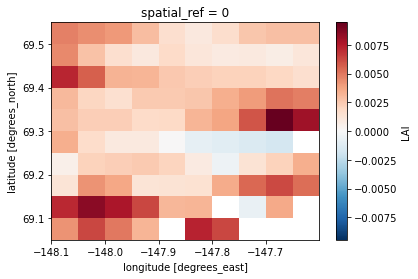

In [7]:
est.plot()

In [6]:
from sklearn.linear_model import TheilSenRegressor
def theilsen(y):
    x = np.arange(len(y)).reshape(-1, 1)
    if np.isnan(y).all():
        return

    I = np.where(np.isnan(y))
    if len(I[0]) > 1:
        return np.nan

    yy = np.delete(y, I)
    x = np.arange(len(yy)).reshape(-1, 1)
    reg = TheilSenRegressor(random_state=1, n_subsamples=20, max_iter=300).fit(x, yy)
    # reg = RANSACRegressor(random_state=1, min_samples=20).fit(x, y)
    return reg.coef_
    # return reg.estimator_.coef_
data = var_ts.values
data.shape
slopes = np.apply_along_axis(theilsen,0,data)

### Calculate natural variability 